Class별로 Test한 결과까지 확인 / 버터링, 다이제 통밀 정확도 다소 낮음 / Normalization 빼고 한번 돌려보기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.optim import lr_scheduler

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import os
import copy
import time
from PIL import Image

Train 및 Validation Transform 설정 및 Dataset 생성

In [ ]:
img_size_mobV2 = 224
# img_size_mobV2 = 64
BatchSize = 16
data_dir = './drive/My Drive/LotteData'

trans_train = {'train' : 
              transforms.Compose([
                            transforms.Resize(img_size_mobV2),
                            torchvision.transforms.ColorJitter((0.3)),
                            torchvision.transforms.RandomRotation(90),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]),
              'val' : 
              transforms.Compose([transforms.Resize(img_size_mobV2),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])
}

trainset = {x : datasets.ImageFolder(os.path.join(data_dir, x), trans_train[x]) for x in ['train', 'val']}

Train Dataset Load

In [ ]:
trainloader = {x: torch.utils.data.DataLoader(trainset[x], batch_size=BatchSize, shuffle=True, num_workers=2) for x in ['train', 'val']}

Train Set, Validataion, Class 갯수 확인

In [ ]:
dataset_sizes = {x: len(trainset[x]) for x in ['train', 'val']}
classes = trainset['train'].classes
print('Train set 수\n: ', dataset_sizes['train'])
print('Validataion set 수\n: ', dataset_sizes['val'])
print('Class 개수\n: ', len(classes))
print(classes)

Train set 수
:  9924
Validataion set 수
:  2505
Class 개수
:  22
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9']


Model : MobileNet V2 / Model Fine-Tuning

In [ ]:
num_class = len(classes)
model = models.mobilenet_v2()

model.classifier[1] = nn.Linear(1280, num_class)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=22, bias=True)
)


Criterion : Cross Entropy Loss / Optimizer : SGD (learning rate = 0.005, momentum = 0.5 / Scheduler : patience 이내에 갱신되지 않으면 Factor(0.8)배로 Learning rate 감소

In [ ]:
# Scheduler Stop patience 값 설정!
scheduler_patience = 8

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.005, momentum=0.5)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.8, patience=scheduler_patience)

Train Model 정의 / Early Stopping 클래스 정의하여, patience 내에 갱신되지 않으면 Stop Train

In [ ]:
EarlyStop_patience = 15
PATH = '/content/drive/My Drive/lotte_mobilenet_v2_ft_13/lotte_mobilenet_v2_ft4.pt'

def train_model(model, criterion, optimizer, scheduler, num_epochs=8):
    global_info = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=EarlyStop_patience, path = PATH, verbose=True)
    for epoch in range(num_epochs):
        local_info = []
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':

                model.train()  # Set model to training mode
            else:

                model.eval()   # Set model to evaluate mode
                if epoch >0:
                    scheduler.step(val_loss)
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in trainloader[phase]:
                inputs = inputs.to(device)
                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

                
                

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'val':
                val_loss = running_loss / dataset_sizes['val']
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            #(Variable(x).data).cpu().numpy()
            if phase == 'train':
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)
            else:
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)



            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        lr_get = get_lr(optimizer)
        print("Current learning rate : {:.8f}".format(lr_get))
        global_info.append(local_info)
        if phase =='val':
            early_stopping(epoch_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

사용 가능한 device 확인

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Train Model : Epoch = 100

In [ ]:
model.to(device)
epochs = 100
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epochs)

Test Transform 설정 및 Dataset 생성

In [ ]:
trans_test = transforms.Compose([transforms.Resize(img_size_mobV2),
                            transforms.ToTensor(),
                            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])

testset = datasets.ImageFolder(os.path.join(data_dir,'test'), transform = trans_test)

Test Dataset Load

In [ ]:
test_BatchSize = 100

testloader = torch.utils.data.DataLoader(testset, batch_size=test_BatchSize, shuffle=False, num_workers=2)

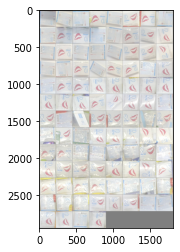

GroundTruth:      0     0     0     0


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

testiter = iter(testloader)
images, labels = testiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
trained_model = models.mobilenet_v2()
trained_model.classifier[1] = nn.Linear(1280, num_class)
# trained_model.load_state_dict(torch.load(PATH))
trained_model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
trained_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

Test !

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = Variable(images.float()), Variable(labels.float())
        
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of test images: %d %%' % (100 * correct / total))


Accuracy of test images: 97 %


In [ ]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = trained_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 100 %
Accuracy of     1 : 83 %
Accuracy of    10 : 100 %
Accuracy of    11 : 100 %
Accuracy of    12 : 100 %
Accuracy of    13 : 100 %
Accuracy of    14 : 100 %
Accuracy of    15 : 91 %
Accuracy of    16 : 100 %
Accuracy of    17 : 100 %
Accuracy of    18 : 100 %
Accuracy of    19 : 100 %
Accuracy of     2 : 100 %
Accuracy of    20 : 100 %
Accuracy of    21 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 91 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 87 %
Accuracy of     8 : 100 %
Accuracy of     9 : 100 %
